In [6]:
from collections import defaultdict
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import pickle5 as pickle
import pymatgen
import gzip

In [7]:
%config InlineBackend.figure_format='retina'


# Distance vs Energy plots

In [11]:
exp_dir_name_mapper = {
    'MoS2-plain-cv': 'MEGNet',
    'MoS2-plain-cv-catboost': 'Catboost+Matminer',
    'MoS2-plain-cv-gemnet': 'GemNet',
    'MoS2-plain-cv-schnet': 'SchNet',
}

exp_name_mapper = {
    'megnet-full.csv.gz': 'MEGNet',
    'megnet-sparse.csv.gz': 'MEGNet-Sparse',
    'catboost-test.csv.gz': 'Catboost+Matminer',
    'schnet-full.csv.gz': 'SchNet',
    'gemnet-full.csv.gz': 'GemNet'
}


In [2]:
targets = pd.read_csv(Path('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/targets.csv.gz'), index_col=0)
folds = pd.read_csv(Path('../datasets/experiments/MoS2-plain-cv/folds.csv'), index_col=0)
targets.columns = pd.MultiIndex.from_product([['DFT'], targets.columns])
targets = targets.assign(folds=folds)


In [3]:
targets

DFT                                   \
                               energy energy_per_atom formation_energy   
_id                                                                      
6141cf0efbfd4bd9ab2c2f7e -1391.340414       -7.284505         2.645686   
6141cf0f51c1cbd9654b8870 -1384.552821       -7.287120         5.306279   
6141cf0fe689ecc4c43cdd4b -1397.196141       -7.277063         0.278959   
6141cf10b842c2e72e2f2d44 -1396.257593       -7.272175         0.579507   
6141cf1051c1cbd9654b8872 -1384.532677       -7.287014         5.326423   
...                               ...             ...              ...   
6148f3f63ac25c70a5c6cdff -1366.470166       -7.230001        12.455734   
6149087231cf3ef3d4a9f848 -1372.565892       -7.224031         9.849008   
6149c48031cf3ef3d4a9f84a -1372.237021       -7.222300        10.177879   
6149f3853ac25c70a5c6ce01 -1367.478625       -7.235337        11.447275   
615083823ac25c70a5c6ce03 -1367.169891       -7.233703        11.756009   

                                                                             \
                         formation_energy_per_site band_gap    homo    lumo   
_id                                                                           
6141cf0efbfd4bd9ab2c2f7e                  2.645686   1.1452 -0.6754  0.4698   
6141cf0f51c1cbd9654b8870                  2.653139   1.0843 -0.6852  0.3991   
6141cf0fe689ecc4c43cdd4b                  0.278959   1.8033 -0.6931  1.1102   
6141cf10b842c2e72e2f2d44                  0.289753   1.8095 -0.6916  1.1179   
6141cf1051c1cbd9654b8872                  2.663212   1.1102 -0.6718  0.4384   
...                                            ...      ...     ...     ...   
6148f3f63ac25c70a5c6cdff                  4.151911   0.3526 -0.5351 -0.1825   
6149087231cf3ef3d4a9f848                  3.283003   0.3002 -0.4501 -0.1499   
6149c48031cf3ef3d4a9f84a                  3.392626   0.3594 -0.5045 -0.1451   
6149f3853ac25c70a5c6ce01                  3.815758   0.5270 -0.6883 -0.1613   
615083823ac25c70a5c6ce03                  3.918670   0.4295 -0.6140 -0.1845   

                                     folds  
                         fermi_level        
_id                                         
6141cf0efbfd4bd9ab2c2f7e   -0.199707     2  
6141cf0f51c1cbd9654b8870   -0.220627     2  
6141cf0fe689ecc4c43cdd4b   -0.183537     3  
6141cf10b842c2e72e2f2d44   -0.179802     5  
6141cf1051c1cbd9654b8872   -0.213190     4  
...                              ...   ...  
6148f3f63ac25c70a5c6cdff   -0.359015     5  
6149087231cf3ef3d4a9f848   -0.300181     6  
6149c48031cf3ef3d4a9f84a   -0.324836     7  
6149f3853ac25c70a5c6ce01   -0.424306     7  
615083823ac25c70a5c6ce03   -0.398333     1  

[5933 rows x 9 columns]

In [40]:
#structures = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')
with gzip.open('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz', "rb") as fh:
    _structures = pickle.load(fh)

In [12]:
predictions = Path('../datasets/predictions').resolve()
predictions = list(predictions.rglob('*.csv.gz'))
# Filter out other directories based on the mapper above
# file.parts[-3] correspond to directory name
predictions = list(filter(
    lambda file: file.parts[-3] in exp_dir_name_mapper.keys(),
    predictions
))

data = defaultdict(dict)
for file in predictions: 
    exp_name = exp_name_mapper.get(file.name)
    # target_name = target_name_mapper.get(file.parts[-2]) 
    target_name = file.parts[-2] 
 
    data[exp_name][target_name] = pd.read_csv(file, index_col=0)

def make_df_from_trial(data: dict, name: str):
    df = pd.concat(data, axis=1)
    df.columns = df.columns.droplevel(-1)
    # Append each attribute with _pred
    # df = df.add_suffix('_pred')
    # Add Higher level index (name of experiment)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    return df

predictions = pd.concat([make_df_from_trial(v, k) for k, v in data.items()], axis=1)
# Concat with actual data
predictions = pd.concat([predictions, targets], axis=1)

# reindex with folds
predictions.index = pd.MultiIndex.from_arrays([predictions.index, predictions.folds])
# drop folds column
predictions = predictions.drop('folds', level=0, axis=1)

In [13]:
predictions

Catboost+Matminer                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2              1.117471                  2.769009   
6141cf0f51c1cbd9654b8870 2              1.057708                  2.659575   
6141cf0fe689ecc4c43cdd4b 3              1.647190                  0.784382   
6141cf10b842c2e72e2f2d44 5              1.804401                  0.184275   
6141cf1051c1cbd9654b8872 4              1.096639                  2.669430   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5              0.356436                  4.146777   
6149087231cf3ef3d4a9f848 6              0.260021                  3.296777   
6149c48031cf3ef3d4a9f84a 7              0.376480                  3.412673   
6149f3853ac25c70a5c6ce01 7              0.363715                  4.090032   
615083823ac25c70a5c6ce03 1              0.374448                  3.986911   

                                            GemNet                            \
                                    homo  band_gap formation_energy_per_site   
_id                      folds                                                 
6141cf0efbfd4bd9ab2c2f7e 2     -0.638735  0.402019                  2.889449   
6141cf0f51c1cbd9654b8870 2     -0.677077  0.406166                  2.948149   
6141cf0fe689ecc4c43cdd4b 3     -0.678564  0.396737                  1.786147   
6141cf10b842c2e72e2f2d44 5     -0.684090  0.376325                  1.078119   
6141cf1051c1cbd9654b8872 4     -0.670878  0.411880                  3.069151   
...                                  ...       ...                       ...   
6148f3f63ac25c70a5c6cdff 5     -0.541923  0.390380                  4.154788   
6149087231cf3ef3d4a9f848 6     -0.432594  0.280273                  3.313599   
6149c48031cf3ef3d4a9f84a 7     -0.507742  0.352018                  3.377668   
6149f3853ac25c70a5c6ce01 7     -0.573291  0.387973                  3.824775   
615083823ac25c70a5c6ce03 1     -0.578072  0.352164                  3.925790   

                                                      SchNet  \
                                    homo      lumo  band_gap   
_id                      folds                                 
6141cf0efbfd4bd9ab2c2f7e 2     -0.657741 -0.195418  0.392363   
6141cf0f51c1cbd9654b8870 2     -0.659049 -0.193416  0.390486   
6141cf0fe689ecc4c43cdd4b 3     -0.589095 -0.152070  0.388200   
6141cf10b842c2e72e2f2d44 5     -0.530069 -0.064264  0.377756   
6141cf1051c1cbd9654b8872 4     -0.585801 -0.212619  0.391952   
...                                  ...       ...       ...   
6148f3f63ac25c70a5c6cdff 5     -0.579105 -0.193635  0.393508   
6149087231cf3ef3d4a9f848 6     -0.434522 -0.158832  0.378598   
6149c48031cf3ef3d4a9f84a 7     -0.505707 -0.154307  0.390690   
6149f3853ac25c70a5c6ce01 7     -0.557184 -0.179236  0.393481   
615083823ac25c70a5c6ce03 1     -0.561668 -0.190133  0.391483   

                                                                    ...  \
                               formation_energy_per_site      homo  ...   
_id                      folds                                      ...   
6141cf0efbfd4bd9ab2c2f7e 2                      4.076340 -0.557408  ...   
6141cf0f51c1cbd9654b8870 2                      4.096680 -0.555105  ...   
6141cf0fe689ecc4c43cdd4b 3                      3.277271 -0.550087  ...   
6141cf10b842c2e72e2f2d44 5                      2.471660 -0.530699  ...   
6141cf1051c1cbd9654b8872 4                      4.089738 -0.561750  ...   
...                                                  ...       ...  ...   
6148f3f63ac25c70a5c6cdff 5                      4.143724 -0.552466  ...   
6149087231cf3ef3d4a9f848 6                      3.345916 -0.531843  ...   
6149c48031cf3ef3d4a9f84a 7                      3.416878 -0.536584  ...   
6149f3853ac25c70a5c6

In [67]:
def defect2_distance(structures):
    d1, d2 = structures
    return d1.distance(d2)


def defect3_distance(structures):
    d1, d2, d3 = structures
    a = d1.distance(d2)
    b = d2.distance(d3)
    c = d1.distance(d3)

    d = np.sort(np.array([a, b, c]))
    v = np.array([1, 0.1, 0.01])

    return (d * v).sum()

def defect3_distance_2(structures):
    get_atom_of_type = lambda atom_type: [atom for atom in structures if atom.properties['was'] == atom_type]
    Mo = get_atom_of_type(42)[0]
    S1, S2 = get_atom_of_type(16)
    a = min([Mo.distance(S1), Mo.distance(S2)])
    b = max([Mo.distance(S1), Mo.distance(S2)])
    c = S1.distance(S2)

    d = np.array([a, b, c])
    v = np.array([1, 0.1, 0.01])
    return np.dot(d, v)

In [45]:
def defects_counter(sites):
    defects = defaultdict(int)
    for s in sites:
        defects[f'z_{s.properties["was"]}'] += 1
    return defects

def num_defects(structures):
    structures['num_defects'] = structures.defect_representation.apply(lambda item: len(item))
    return structures

def vacancy_defects(structures):
    structures['V'] = structures.defect_representation.apply(lambda sites: list(filter(lambda site: site.species_string == 'X0+', sites))) \
                                                      .apply(lambda sites: defects_counter(sites))

    structures = pd.concat([structures, structures.V.apply(pd.Series, dtype=object)], axis=1)
    return structures


def defects_distance_v2(structures):
    v2 = structures.query('z_16==1 and z_42==1 and num_defects==2')
    return pd.Series(v2['defect_representation'].apply(defect2_distance), name='distance')

def defects_distance_v3(structures):
    v3 = structures.query('z_16==2 and z_42==1 and num_defects==3')
    return pd.Series(v3['defect_representation'].apply(defect3_distance_2), name='distance')


In [66]:
v2 = defects_distance_v2(
    vacancy_defects(
        num_defects(
            _structures
        )
    )
)

In [17]:
v2

_id
6141cf1202d926221cabc545    12.964839
6141cf1302d926221cabc547     9.370277
6141cf1302d926221cabc549    13.002467
6141cf1502d926221cabc54b     3.987968
6141cf1602d926221cabc54d     7.545995
6141cf1702d926221cabc54f    12.161154
6141cf1802d926221cabc551     8.202622
6141cf1b02d926221cabc553     9.849015
6141cf1d02d926221cabc555    13.382056
6141cf2202d926221cabc557    11.286035
6141cf2602d926221cabc559     5.122973
6141cf3802d926221cabc55b    10.392087
6141cf3d02d926221cabc55d     6.802601
6141cf4b02d926221cabc55f     2.392859
6141cf8902d926221cabc561    14.803394
Name: distance, dtype: float64

In [19]:
targets.loc['6141cf4b02d926221cabc55f']

DFT    energy                      -1375.253500
       energy_per_atom                -7.238176
       formation_energy                7.799400
       formation_energy_per_site       3.899700
       band_gap                        0.300600
       homo                           -0.496200
       lumo                           -0.195600
       fermi_level                    -0.345723
folds                                  7.000000
Name: 6141cf4b02d926221cabc55f, dtype: float64

In [68]:
v3 = defects_distance_v3(
    vacancy_defects(
        num_defects(
            _structures
        )
    )
)

In [53]:
def plot(d, e, legend, ax, color, alpha=0.5, **kwargs):
    args = np.argsort(d)
    ax.plot(d[args], e[args], 'o', color=color, label=legend, mfc='white', **kwargs)

    ax.plot(d[args], e[args], alpha=alpha, color=color, zorder=-1)
    ax.legend()
    return ax

Text(0.5, 1.0, 'V2')

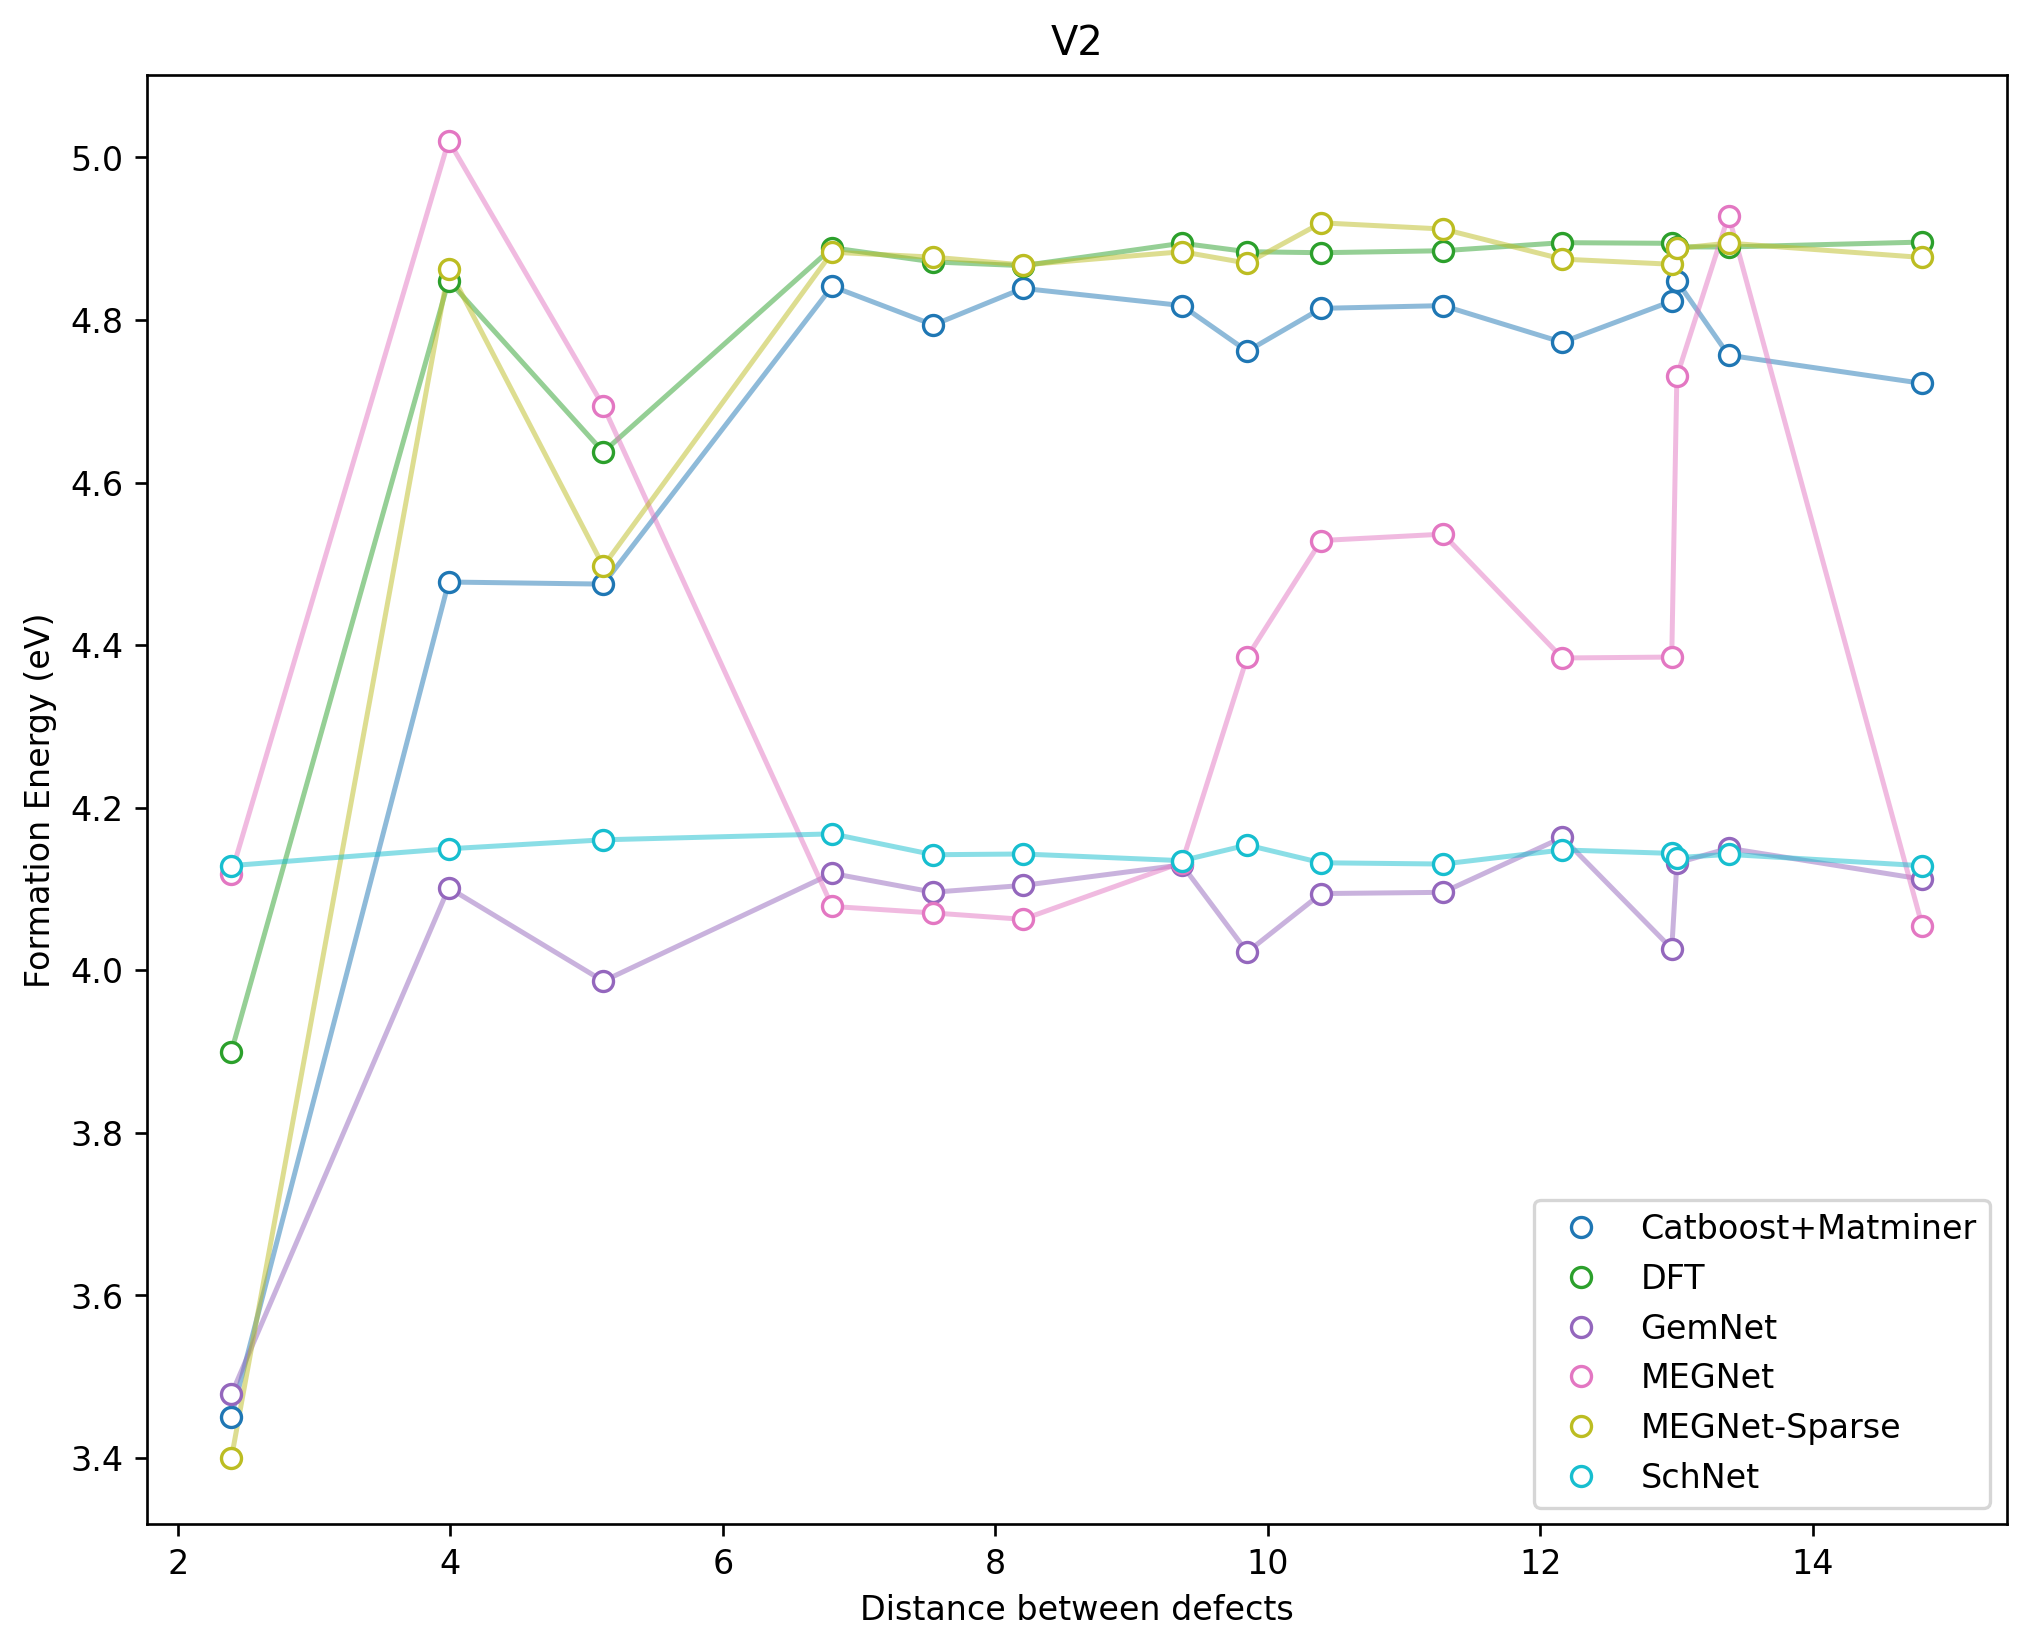

In [72]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    plot(
        pred.v2,
        pred.formation_energy_per_site,
        legend=legend,
        color=next(colors),
        ax=ax,
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Distance between defects')
ax.set_title('V2')

Text(0.5, 1.0, 'V3')

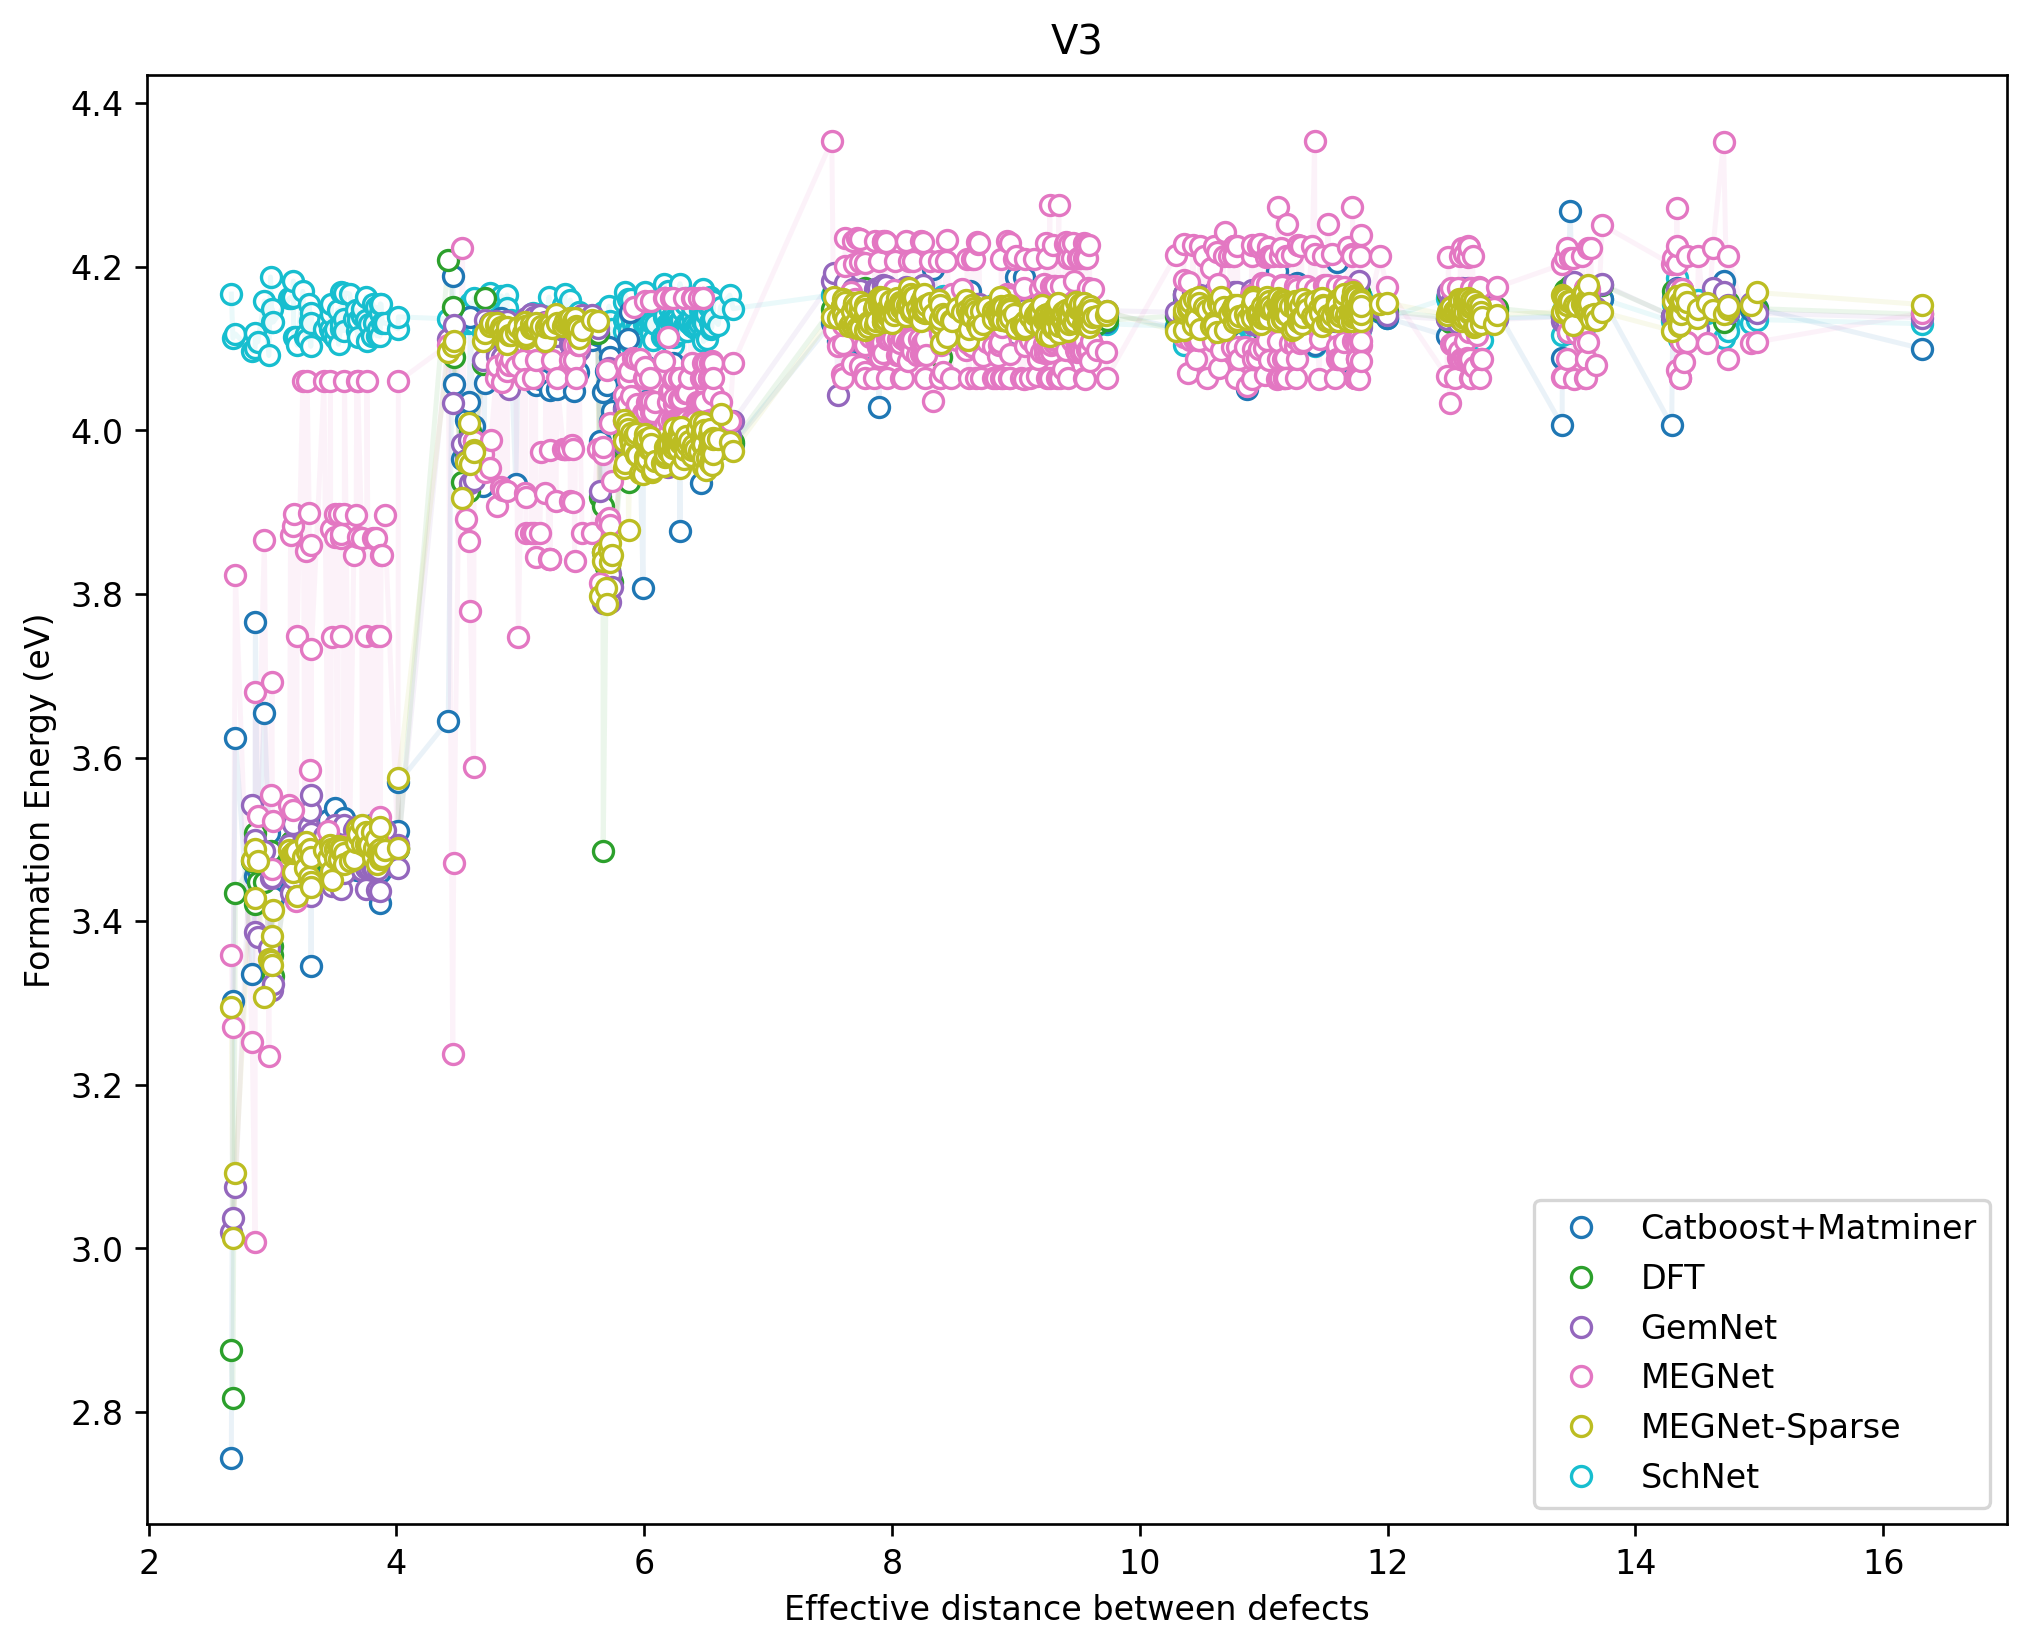

In [71]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)

    plot(
        pred.v3,
        pred.formation_energy_per_site,
        legend=legend,
        ax=ax,
        color=next(colors),
        alpha=0.09,
        zorder=-1 if 'SchNet' in legend else 1
    )

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Effective distance between defects')
ax.set_title('V3')

Text(0.5, 1.0, 'V3')

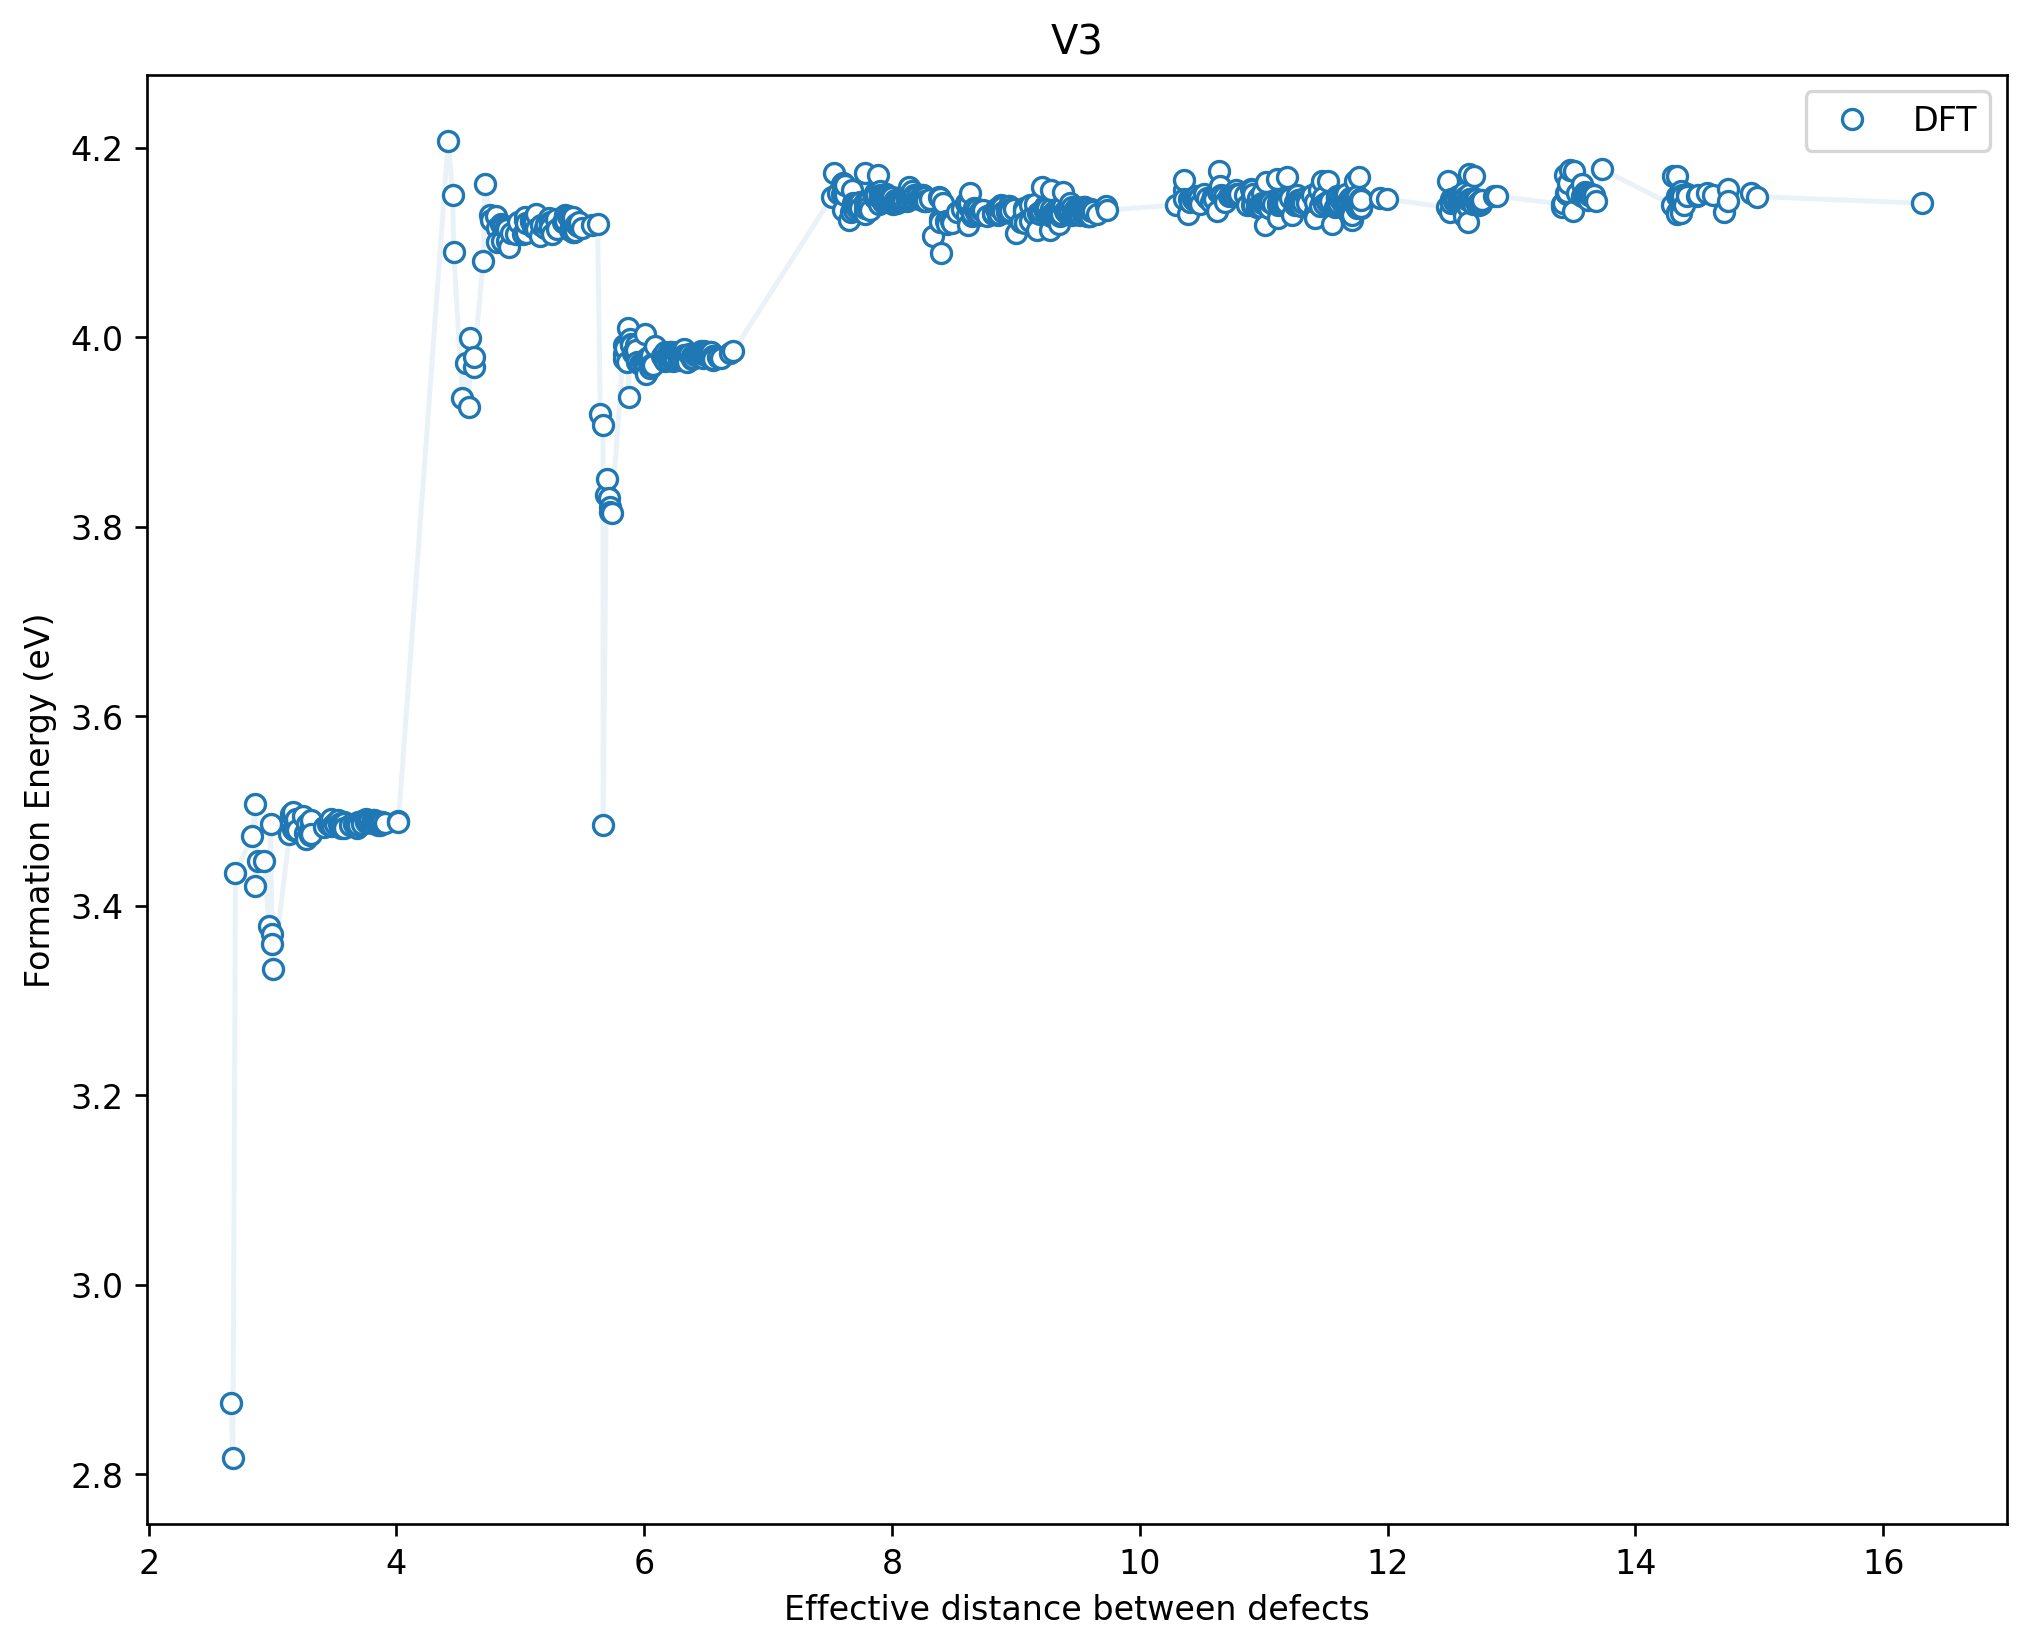

In [70]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)
    if 'DFT' == g:
        plot(
            pred.v3,
            pred.formation_energy_per_site,
            legend=legend,
            ax=ax,
            color=next(colors),
            alpha=0.09,
            zorder=-1 if 'SchNet' in legend else 1
        )
        break

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Effective distance between defects')
ax.set_title('V3')